In [1]:
import re
import pandas as pd
import regex as re
from underthesea import word_tokenize
from langdetect import detect
from pyvi import ViTokenizer, ViPosTagger # thư viện NLP tiếng Việt

In [2]:
# Đọc nội dung từ file text
with open("datafn.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# Tạo DataFrame từ nội dung
data = []
for line in lines:
    parts = line.strip().split(" ", 1)
    if len(parts) == 2:
        data.append(parts)
df = pd.DataFrame(data, columns=["label", "content"])

# Hiển thị DataFrame
print(df)

                    label                                            content
0       __label__giải_trí  Hỗn Độn chân giới bị Ma Uyên chân giới mở thôn...
1      __label__tài_chính  Ngân hàng Nhà nước đã đồng loạt tăng lãi suất ...
2      __label__tài_chính  (22/05/2024 21:00) GS Phan Văn Trường đã đưa r...
3      __label__tài_chính  2024-05-22T16:59:00 Ủy ban Thường vụ Quốc hội ...
4      __label__tài_chính  2024-05-22T08:00:00 Năm 2023 được đánh giá tiế...
...                   ...                                                ...
24846  __label__chính_phủ  214/BC-UBND 02/05/2024 Tình hình kinh tế - xã ...
24847  __label__chính_phủ  894/QĐ-UBND 18/05/2024 Về việc phê duyệt Danh ...
24848  __label__chính_phủ  140/BC-UBND 20/03/2024 Báo cáo Kết quả công tá...
24849  __label__chính_phủ               Cổng thông tin điện tử tỉnh Lạng Sơn
24850  __label__chính_phủ  867/QĐ-UBND 13/05/2024 Về việc tặng Bằng khen ...

[24851 rows x 2 columns]


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24851 entries, 0 to 24850
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    24851 non-null  object
 1   content  24851 non-null  object
dtypes: object(2)
memory usage: 388.4+ KB


In [4]:
df.describe()

,label,content
count,24851,24851
unique,15,16449
top,__label__TMDT,Mã xác nhận OTP đã được gửi về số điện thoại: ...
freq,2069,446


In [5]:
# Kiểm tra giá trị rỗng trong DataFrame
missing_values = df.isnull().sum()
print(missing_values)


label      0
content    0
dtype: int64


In [6]:
#xoá các dòng dữ liệu lặp
df = df.drop_duplicates()
#xoá các dòng dữ liệu thiếu
df.dropna(inplace=True)

In [7]:
#các hàm tiền xử lý
# xóa html code
def remove_html_tags(text):
    # Loại bỏ các thẻ HTML
    text = re.sub(r'<[^>]+>', '', text)
    return text
# Loại bỏ các thẻ code, mã JavaScript và mã CSS
def remove_code(text):
    # Loại bỏ các thẻ code, mã JavaScript và mã CSS
    text = re.sub(r'<script.?>.?</script>', '', text, flags=re.DOTALL)
    text = re.sub(r'<style.?>.?</style>', '', text, flags=re.DOTALL)
    return text

# xóa các ký tự không cần thiết
def remove_special_characters(text):
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]', ' ', text)
    return text

# Loại bỏ nội dung trong các dấu ngoặc nhọn {{...}}
def remove_curly_braces_content(text):
    # Loại bỏ nội dung trong các dấu ngoặc nhọn {{...}}
    text = re.sub(r'{{.*?}}', '', text)
    return text

#tạo từ điển dicchar để ánh xạ các ký tự tiếng Việt có dấu sang ký tự không dấu tương ứng
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

# từ điển để thay thế các ký tự tiếng Việt có dấu bằng các ký tự không dấu tương ứng.
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
dicchar = loaddicchar()

# Hàm chuyển Unicode dựng sẵn về Unicde tổ hợp
def convert_unicode(text):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], text)

bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)


def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            # for index2 in nguyen_am_index:
            #     if index2 != index:
            #         x, y = nguyen_am_to_ids[chars[index]]
            #         chars[index2] = bang_nguyen_am[x][0]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)


def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True

# chuẩn hóa cách gõ dấu tiếng Việt
def chuan_hoa_dau_cau_tieng_viet(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

# tách từ
def tokenize_text(text):
    return word_tokenize(text, format="text")
    
# đưa về lower
def convert_to_lowercase(text):
    return text.lower()

# xóa khoảng trắng thừa
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

# Hàm kiểm tra ngôn ngữ
def is_vietnamese(text):
    try:
        lang = detect(text)
        return lang == 'vi'
    except:
        return False




In [8]:
# áp dụng các hàm tiền xử lý
df_cleaned = df.apply(lambda x: x.map(remove_html_tags))
df_cleaned = df_cleaned.apply(lambda x: x.map(remove_code))
df_cleaned = df_cleaned.apply(lambda x: x.map(remove_curly_braces_content))
df_cleaned = df_cleaned.apply(lambda x: x.map(remove_special_characters))
df_cleaned = df_cleaned[df_cleaned['content'].apply(is_vietnamese)]
df_cleaned = df_cleaned.apply(lambda x: x.map(convert_unicode))
df_cleaned = df_cleaned.apply(lambda x: x.map(chuan_hoa_dau_cau_tieng_viet))
df_cleaned = df_cleaned.apply(lambda x: x.map(tokenize_text))
df_cleaned = df_cleaned.apply(lambda x: x.map(convert_to_lowercase))
df_cleaned = df_cleaned.apply(lambda x: x.map(remove_extra_spaces))
# Xóa các dòng có giá trị là chuỗi rỗng trong cột "content"
df_cleaned = df_cleaned[df_cleaned['content'] != ""]


In [32]:
file_path = "website_cat.txt"
df_cleaned.to_csv(file_path, sep='\t', index=False, header=None)


In [33]:
# Thống kê số lượng data theo nhãn

count = {}
with open('website_cat.txt') as file:
    for line in file:
        words = line.split()
        if words:  # Kiểm tra xem danh sách words có phần tử nào không
            key = words[0]
            count[key] = count.get(key, 0) + 1

for key in count:
    print(key, count[key])


__label__giải_trí 623
__label__tài_chính 1173
__label__nghề_nghiệp 867
__label__sức_khỏe 1338
__label__tài_liệu 446
__label__thể_thao 840
__label__thực_phẩm 1118
__label__tin_tức 1434
__label__tmdt 1372
__label__xe_cộ 1162
__label__cộng_đồng 1245
__label__động_vật 1154
__lable__du_lịch 890
__label__khoa_học 896
__label__chính_phủ 1397


In [34]:
# Thống kê số lượng data theo nhãn

count = {}
with open('website_cat.txt') as file:
    for line in file:
        words = line.split()
        if words:  # Kiểm tra xem danh sách words có phần tử nào không
            key = words[0]
            count[key] = count.get(key, 0) + 1
sum=0
for key in count:
    sum=count[key]+sum
print(sum)

15955


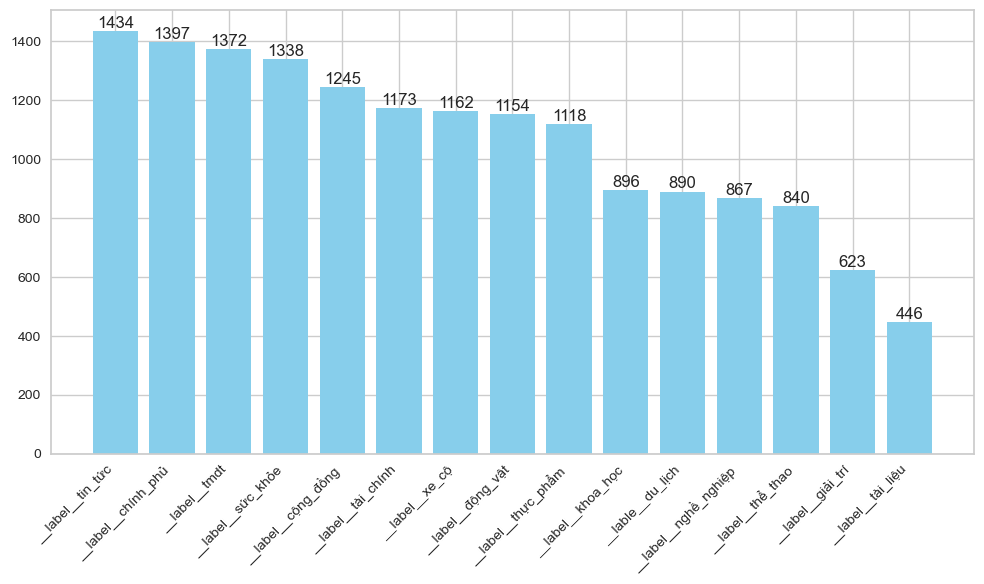

In [35]:
import matplotlib.pyplot as plt
# Sắp xếp dữ liệu theo số lượng từ lớn đến bé

sorted_count = dict(sorted(count.items(), key=lambda item: item[1], reverse=True))

# Vẽ biểu đồ
labels = list(sorted_count.keys())
values = list(sorted_count.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color='skyblue')

# Thêm số liệu trên đầu mỗi cột nhãn
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('countlabel.pdf')
plt.show()


In [59]:
# Đọc danh sách stopword từ file từ điển
stopword = set()
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as stopword_file:
    for word in stopword_file:
        stopword.add(word.strip())

    
def remove_stopwords(line):
    words = []
    for word in line.strip().split():
        if word not in stopword:
            words.append(word)
    return ' '.join(words)
    
    
with open('website_cat.prep', 'w') as fp:
    for line in open('website_cat.txt'):
        line = remove_stopwords(line)
        fp.write(line + '\n')


In [60]:
!head website_cat.txt

__label__giải_trí	hỗn_độn chân_giới bị ma_uyên chân_giới mở thông_đạo xâm_lấn vô_tận đọc truyện tương_lai trái_đất nhân_loại đi vào vũ_trụ thực_dân các tinh_cầu tất_cả đọc truyện trò_chơi này cũng quá chân_thật a đánh như_thế_nào lấy đánh lấy đồng đọc truyện ta nhiều lần cường_điệu tu_tiên_giới tập_tục vốn chính là lệch không đọc truyện tiên_đạo khó_khăn vô_cùng huống_chi tu tiên_giới này còn bị một hồi_ôn đọc truyện đây là một bộ đồng_nhân naruto đồng_nhân naruto thì trên mạng convert khá đọc truyện
__label__tài_chính	ngân_hàng nhà_nước đã đồng_loạt tăng lãi_suất omo và lãi_suất tín_phiếu phiên 22 5 trong bối_cảnh tỷ giá usd liên_tục được các ngân_hàng niêm_yết sát_trần và cao hơn giá bán can_thiệp
__label__tài_chính	22 05 2024 21 00 gs phan_văn_trường đã đưa ra những lời khuyên chia_sẻ nhiều bài_học giá_trị cho người trẻ theo giáo_sư nhiều người mắc một cái bệnh đó là hay tính_toán vị giáo_sư 78 tuổi cho rằng thay_vì tính_toán nặng_nề chúng_ta nên sống vô_tư thơ_thới hơn cùng với đó 

In [61]:
# Chia tập train/test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
test_percent = 0.2

text = []
label = []

for line in open('website_cat.prep'):
    words = line.strip().split()
    label.append(words[0])
    text.append(' '.join(words[1:]))

X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=test_percent, random_state=42)

# Lưu train/test data
# Giữ nguyên train/test để về sau so sánh các mô hình cho công bằng
with open('train.txt', 'w') as fp:
    for x, y in zip(X_train, y_train):
        fp.write('{} {}\n'.format(y, x))

with open('test.txt', 'w') as fp:
    for x, y in zip(X_test, y_test):
        fp.write('{} {}\n'.format(y, x))

# encode label
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print(list(label_encoder.classes_), '\n')
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

print(X_train[0], y_train[0], '\n')
print(X_test[0], y_test[0])

['__label__chính_phủ', '__label__cộng_đồng', '__label__giải_trí', '__label__khoa_học', '__label__nghề_nghiệp', '__label__sức_khỏe', '__label__thể_thao', '__label__thực_phẩm', '__label__tin_tức', '__label__tmdt', '__label__tài_chính', '__label__tài_liệu', '__label__xe_cộ', '__label__động_vật', '__lable__du_lịch'] 

lựa_chọn vợt cầu lông giá rẻ câu liệu sản_phẩm kết_hợp hoàn_hảo tính_năng thiết_kế đáp_án dòng vợt cầu lông_felet biểu_tượng kết_hợp tính_năng kiểu_dáng chi_tiết công_nghệ tiên_tiến felet sản_phẩm giúp nâng hiệu_quả thi_đấu mà_còn trải_nghiệm thú_vị vợt giới_thiệu vợt cầu lông felet felet ngừng đổi_mới đầu_tư công_nghệ trải_nghiệm lông_thủ đề_cao cảm_nhận cú đánh công_nghệ tiên_tiến felet áp_dụng công_nghệ chấn_động shock absorption giúp giảm_thiểu phản_lực áp_lực cổ_tay_trong giúp cải_thiện hiệu_quả thi_đấu mà_còn giúp thể_lực cổ_tay trận đấu vợt cầu lông felet đồng_hành chiến_thắng dừng công_nghệ felet thiết_kế vợt đáp_ứng tình_huống sân vợt tập kinh_nghiệm dòng sản_phẩm cu

In [62]:
MODEL_PATH = "models"

import os
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [63]:
import pickle
import time
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

start_time = time.time()

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1),
                               max_df=0.8,
                               max_features=None)), 
    ('clf', MultinomialNB())
])
text_clf = text_clf.fit(X_train, y_train)

train_time_nb = time.time() - start_time
print('Done training Naive Bayes in', train_time_nb, 'seconds.')

# Save model
pickle.dump(text_clf, open(os.path.join(MODEL_PATH, "naive_bayes.pkl"), 'wb'))

Done training Naive Bayes in 1.9162030220031738 seconds.


<Axes: title={'center': 'MultinomialNB Classification Report'}>

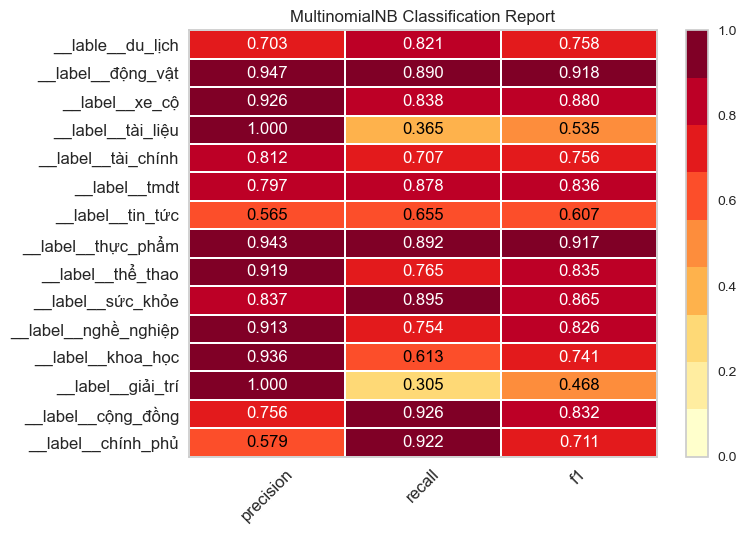

In [64]:
import pickle
import os
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport

# Load the trained Naive Bayes model
nb_model = pickle.load(open(os.path.join(MODEL_PATH, "naive_bayes.pkl"), 'rb'))

# Assuming you have X_train, y_train, X_test, y_test already defined
# y_train and y_test should be in encoded format

# Create a classification report visualizer
visualizer = ClassificationReport(nb_model, support=False,classes=list(label_encoder.classes_))

# Fit the visualizer with the training data
visualizer.fit(X_train, y_train)  

# Evaluate the model with the test data
visualizer.score(X_test, y_test)  
# Display the visualization
visualizer.show(outpath="nb_report.pdf")


In [65]:
from sklearn.linear_model import LogisticRegression
    
start_time = time.time()
text_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,1),
                               max_df=0.8,
                               max_features=None)),
                     ('clf', LogisticRegression(solver='newton-cg', 
                                                multi_class='auto',
                                                max_iter=10000))
                    ])


text_clf = text_clf.fit(X_train, y_train)

train_time_lg = time.time() - start_time
print('Done training Logistic Regression in', train_time_lg, 'seconds.')

# Save model
pickle.dump(text_clf, open(os.path.join(MODEL_PATH, "logistic_regression.pkl"), 'wb'))

Done training Logistic Regression in 14.112133979797363 seconds.


<Axes: title={'center': 'LogisticRegression Classification Report'}>

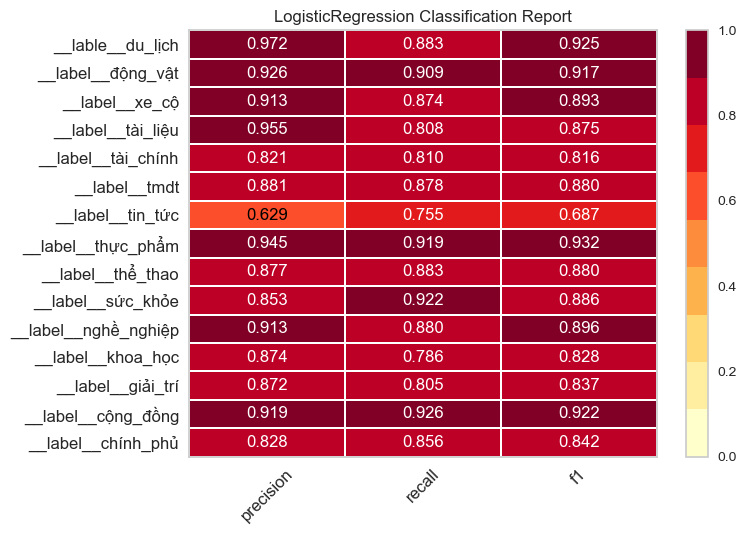

In [66]:
import pickle
import os
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport

lg_model = pickle.load(open(os.path.join(MODEL_PATH,"logistic_regression.pkl"), 'rb'))

# Create a classification report visualizer
visualizer = ClassificationReport(lg_model, support=False,classes=list(label_encoder.classes_))

# Fit the visualizer with the training data
visualizer.fit(X_train, y_train)  

# Evaluate the model with the test data
visualizer.score(X_test, y_test)  
# Display the visualization
visualizer.show(outpath="lr_report.pdf")


In [67]:
from sklearn.svm import SVC

start_time = time.time()
text_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,1),
                               max_df=0.8,
                               max_features=None)),
                     ('clf', SVC(gamma='scale'))
                    ])
text_clf = text_clf.fit(X_train, y_train)

train_time_svm = time.time() - start_time
print('Done training SVM in', train_time_svm, 'seconds.')

# Save model
pickle.dump(text_clf, open(os.path.join(MODEL_PATH, "svm.pkl"), 'wb'))

Done training SVM in 148.01631832122803 seconds.


<Axes: title={'center': 'SVC Classification Report'}>

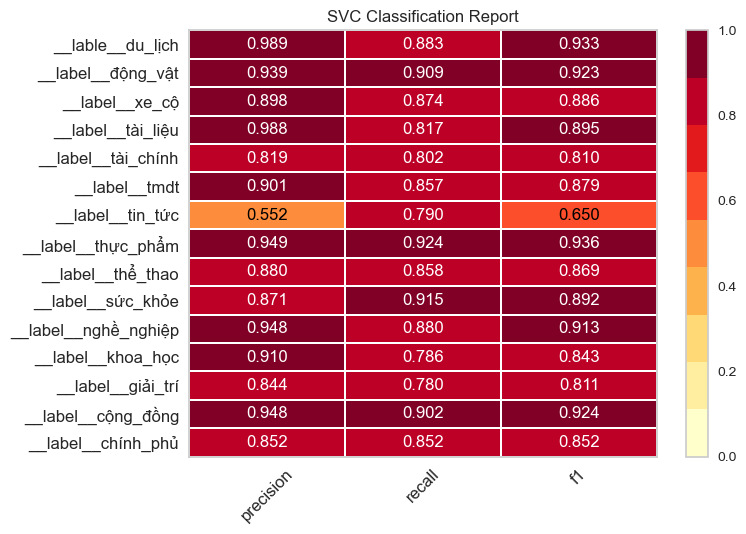

In [68]:
import pickle
import os
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport

svm_model = pickle.load(open(os.path.join(MODEL_PATH,"svm.pkl"), 'rb'))

# Create a classification report visualizer
visualizer = ClassificationReport(svm_model, support=False,classes=list(label_encoder.classes_))

# Fit the visualizer with the training data
visualizer.fit(X_train, y_train)  

# Evaluate the model with the test data
visualizer.score(X_test, y_test)  
# Display the visualization
visualizer.show(outpath="svm_report.pdf")


In [69]:
# Xem kết quả trên từng nhãn
from sklearn.metrics import classification_report

svm_model = pickle.load(open(os.path.join(MODEL_PATH,"svm.pkl"), 'rb'))
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=list(label_encoder.classes_)))

                      precision    recall  f1-score   support

  __label__chính_phủ       0.85      0.85      0.85       270
  __label__cộng_đồng       0.95      0.90      0.92       244
   __label__giải_trí       0.84      0.78      0.81       118
   __label__khoa_học       0.91      0.79      0.84       168
__label__nghề_nghiệp       0.95      0.88      0.91       167
   __label__sức_khỏe       0.87      0.91      0.89       258
   __label__thể_thao       0.88      0.86      0.87       162
  __label__thực_phẩm       0.95      0.92      0.94       223
    __label__tin_tức       0.55      0.79      0.65       290
       __label__tmdt       0.90      0.86      0.88       287
  __label__tài_chính       0.82      0.80      0.81       232
   __label__tài_liệu       0.99      0.82      0.89       104
      __label__xe_cộ       0.90      0.87      0.89       253
   __label__động_vật       0.94      0.91      0.92       219
    __lable__du_lịch       0.99      0.88      0.93       196

      

In [70]:
import pickle
import os
import numpy as np
# Naive Bayes
model = pickle.load(open(os.path.join(MODEL_PATH,"naive_bayes.pkl"), 'rb'))
y_pred_nb = model.predict(X_test)
print('Naive Bayes, Accuracy =', np.mean(y_pred_nb == y_test))

# Linear Classifier
model = pickle.load(open(os.path.join(MODEL_PATH,"logistic_regression.pkl"), 'rb'))
y_pred_lg = model.predict(X_test)
print('Logistic Regression, Accuracy =', np.mean(y_pred_lg == y_test))

# SVM
model = pickle.load(open(os.path.join(MODEL_PATH,"svm.pkl"), 'rb'))
y_pred_svm = model.predict(X_test)
print('SVM, Accuracy =', np.mean(y_pred_svm == y_test))



Naive Bayes, Accuracy = 0.7853337511751802
Logistic Regression, Accuracy = 0.8627389533061736
SVM, Accuracy = 0.8589783766844249


Naive Bayes, Accuracy = 0.8207604103802052
Logistic Regression, Accuracy = 0.9044457855562261
SVM, Accuracy = 0.9106819553409776

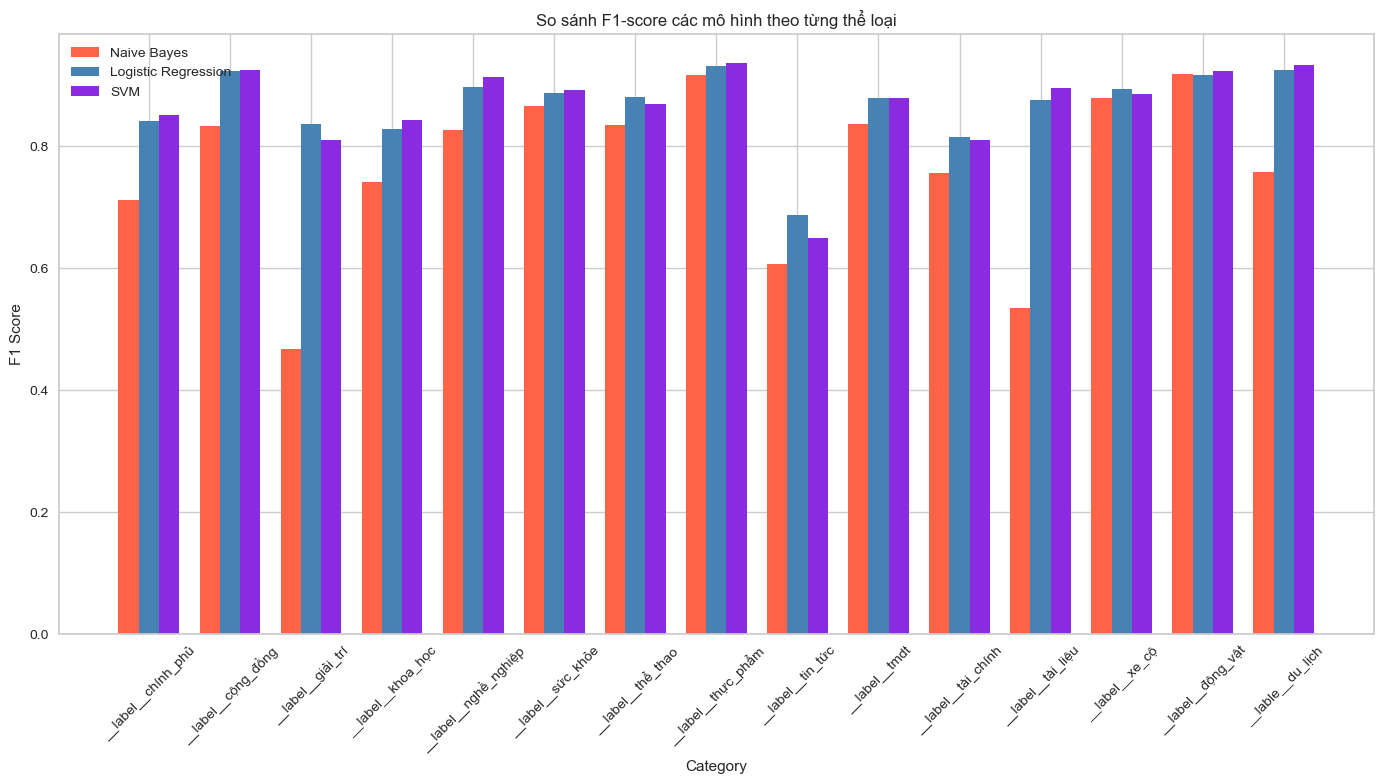

In [71]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Assuming you have X_test and y_test already defined
target_names = list(label_encoder.classes_)

# Function to extract f1-scores from classification_report
def get_f1_scores(model, X_test, y_test, target_names):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    f1_scores = {label: report[label]['f1-score'] for label in target_names}
    return f1_scores

# Load models and get f1-scores
nb_model = pickle.load(open(os.path.join(MODEL_PATH, "naive_bayes.pkl"), 'rb'))
f1_scores_nb = get_f1_scores(nb_model, X_test, y_test, target_names)

lr_model = pickle.load(open(os.path.join(MODEL_PATH, "logistic_regression.pkl"), 'rb'))
f1_scores_lr = get_f1_scores(lr_model, X_test, y_test, target_names)

svm_model = pickle.load(open(os.path.join(MODEL_PATH, "svm.pkl"), 'rb'))
f1_scores_svm = get_f1_scores(svm_model, X_test, y_test, target_names)

# Create DataFrame for plotting
f1_df = pd.DataFrame({
    'Category': target_names,
    'Naive Bayes': list(f1_scores_nb.values()),
    'Logistic Regression': list(f1_scores_lr.values()),
    'SVM': list(f1_scores_svm.values())
})

# Plot the data
plt.figure(figsize=(14, 8))
bar_width = 0.25
index = np.arange(len(target_names))

bar1 = plt.bar(index, f1_df['Naive Bayes'], bar_width, label='Naive Bayes', color='#FF6347')
bar2 = plt.bar(index + bar_width, f1_df['Logistic Regression'], bar_width, label='Logistic Regression', color='#4682B4')
bar3 = plt.bar(index + 2 * bar_width, f1_df['SVM'], bar_width, label='SVM', color='#8A2BE2')

plt.xlabel('Category')
plt.ylabel('F1 Score')
plt.title('So sánh F1-score các mô hình theo từng thể loại')
plt.xticks(index + bar_width, target_names, rotation=45)
plt.legend()

plt.tight_layout()
plt.savefig('f1_score_comparison.pdf')  # Save the plot as a PDF file
plt.show()



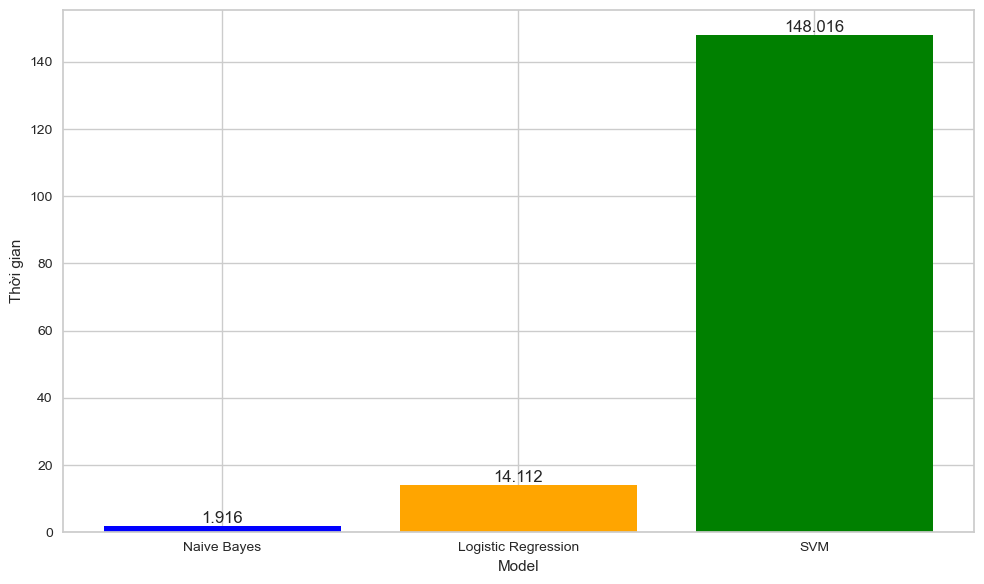

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Độ chính xác của các mô hình
train_times = {
    'Naive Bayes': train_time_nb,
    'Logistic Regression': train_time_lg,
    'SVM': train_time_svm
}

# Tạo biểu đồ
plt.figure(figsize=(10, 6))
models = list(train_times.keys())
train_time_values = list(train_times.values())

plt.bar(models, train_time_values, color=['blue', 'orange', 'green'])

# Thêm tiêu đề và nhãn trục
plt.xlabel('Model')
plt.ylabel('Thời gian')

# Hiển thị giá trị trên cột
for i, value in enumerate(train_time_values):
    plt.text(i, value, f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('traintime.pdf')
plt.show()


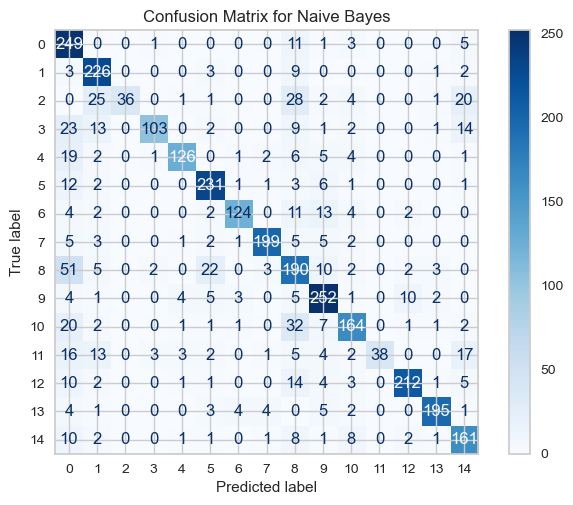

In [73]:
import numpy as np
import pickle
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Tạo ma trận nhầm lẫn cho svm
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=model.classes_)
disp_nb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Naive Bayes')
plt.savefig('cm_nb.pdf')
plt.show()


In [74]:
import pandas as pd
hello=pd.DataFrame(target_names)
hello

,0
0,__label__chính_phủ
1,__label__cộng_đồng
2,__label__giải_trí
3,__label__khoa_học
4,__label__nghề_nghiệp
5,__label__sức_khỏe
6,__label__thể_thao
7,__label__thực_phẩm
8,__label__tin_tức
9,__label__tmdt


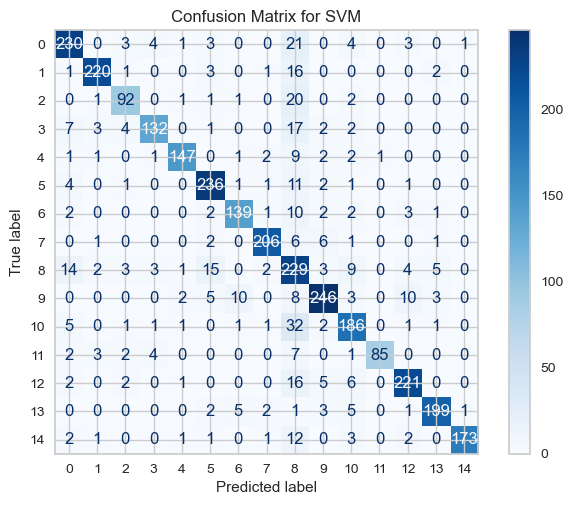

In [75]:
import numpy as np
import pickle
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Tạo ma trận nhầm lẫn cho svm
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=model.classes_)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM')
plt.savefig('cm_svm.pdf')
plt.show()


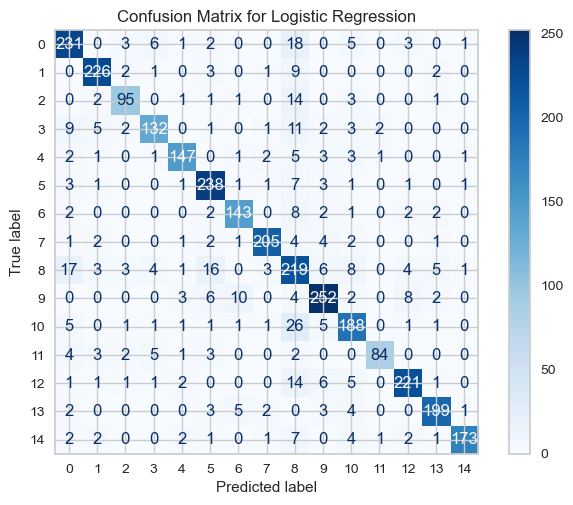

In [76]:
import numpy as np
import pickle
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Tạo ma trận nhầm lẫn cho svm
cm_lg = confusion_matrix(y_test, y_pred_lg)
disp_lg = ConfusionMatrixDisplay(confusion_matrix=cm_lg, display_labels=model.classes_)
disp_lg.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.savefig('cm_lg.pdf')
plt.show()


In [77]:
#•	Phân tích các mẫu dự đoán sai giúp hiểu các đặc điểm dẫn đến sự nhầm lẫn.
errors = []
for i in range(len(y_test)):
    if y_pred_nb[i] != y_test[i]:
        errors.append(X_test[i])

errors = np.array(errors)



In [78]:
print(errors)

['vá i vá trã chá_tá ch hä qt táº p ä õa n træ á_ng thã nh_vía t nam_vã hía n ä ang ä ía_u hã nh trá c tiáº p teg ã ng cã thá chia sáº cæ duỹaªn nã o khiáº n ã ng gáº n bã vá i lä nh vá c nä ng læ ng_vã nhá ng dáº_u má c trãªn cháº ng ä æ á_ng nã y_vã o ä áº_u nä m 2011 sá cá táº i nhã_mã y_ä ía n háº t_nhã n fukushima dai_ichi táº i nháº t báº n ä ã lã m rung ä á_ng thá træ á_ng tõa n cáº_u nhá ng con_sá thía t háº i vá ngæ i váº t cháº t_vã háº_u quáº kã o_dã i tháº t_sá ráº t ã m áº nh khiáº n tã i khã ng ngá ng trä n trá vá cã_u chuýa n phã t tría n nä ng læ á_ng phá c vá thá nh væ á_ng c gia_nhæ ng pháº i gáº n lía n vá i an_tõa n_vã bá_n vá ng cå ng chã nh nhá ng suy_tæ nã y_ä ã thãºc ä áº y_tã i hã nh ä á_ng ä á_hía n thá c hõa cæ há i phã t tría n nä ng læ á_ng tã i táº o táº i_vía t nam tá nhá ng nä m 2012 2013 tã i_vã cã c ä ng_sá ä ã báº t ä áº_u ä ã o sã_u tã m hía_u lä nh vá c nä ng læ á_ng há c há i_tá thá træ á_ng tõa n cáº_u lä n lá n thá c táº táº i cã c ä á_a phæ æ ng

In [79]:
from collections import Counter
import pandas as pd

# Hàm lấy tần suất xuất hiện của từng từ trong mỗi nhãn
def get_word_frequencies(corpus):
    return Counter(" ".join(corpus).split())

# Tạo từ điển tần suất từng từ cho mỗi nhãn
word_freqs = {}
for label in model.classes_:
    label_indices = [i for i, y in enumerate(y_train) if y == label]  # Lấy chỉ số của các mẫu có nhãn là 'label'
    label_corpus = [X_train[i] for i in label_indices]  # Lấy các mẫu tương ứng với nhãn 'label'
    word_freqs[label] = get_word_frequencies(label_corpus)

# Chuyển từ điển thành DataFrame
word_freqs_df = pd.DataFrame(word_freqs).fillna(0)


In [80]:
#•	Phân tích tần suất từ ngữ giúp nhận biết các từ ngữ phổ biến và gây nhầm lẫn.
word_freqs_df[:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
danh_bạ,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,9.0,1.0,2.0,0.0,0.0
điện_tử,454.0,36.0,17.0,27.0,56.0,24.0,33.0,65.0,115.0,189.0,218.0,22.0,198.0,11.0,58.0
sở,1119.0,15.0,5.0,31.0,10.0,66.0,6.0,7.0,173.0,9.0,48.0,11.0,616.0,7.0,11.0
giáo_dục,874.0,160.0,2.0,223.0,95.0,41.0,1.0,5.0,175.0,32.0,37.0,20.0,3.0,7.0,10.0
đào_tạo,630.0,89.0,3.0,516.0,372.0,310.0,13.0,63.0,158.0,22.0,44.0,50.0,948.0,35.0,12.0
lào_cai,844.0,0.0,0.0,1.0,10.0,6.0,40.0,1.0,48.0,4.0,7.0,1.0,11.0,0.0,93.0
bao_gồm,830.0,815.0,60.0,85.0,312.0,752.0,165.0,251.0,187.0,579.0,502.0,104.0,525.0,386.0,329.0
website,142.0,86.0,46.0,84.0,325.0,70.0,68.0,386.0,27.0,849.0,271.0,212.0,161.0,63.0,131.0
email,416.0,46.0,12.0,76.0,363.0,52.0,42.0,98.0,22.0,347.0,201.0,154.0,136.0,133.0,379.0
điện_thoại,390.0,38.0,41.0,36.0,236.0,91.0,254.0,91.0,116.0,631.0,528.0,41.0,251.0,34.0,662.0
